In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nagrade = {'a1':0, 'a2':0, 'a3':0, 'a4':0, 'a5':0, 'b1':-1, 'b3':-1, 'b5':3}

In [ ]:
def simulator(pocetno_stanje,akcija,stohasticnost = True):
  # provjera da nismo u terminalnom stanju
  if pocetno_stanje[0] == 'b':
    return 'a1', nagrade[pocetno_stanje], True
  # modeliranje stohasticnosti okruzenja
  if stohasticnost:
    p = np.random.rand()
    if p <= 0.2:
      akcija = akcija + 1
    elif p <= 0.4:
      akcija = akcija -1
    akcija = akcija % 4 
    
  pocetno_stanje = int(pocetno_stanje[1])
  kraj_epizode = False
  novo_stanje = pocetno_stanje
  # kretanje
  if akcija == 1:
    if not(pocetno_stanje == 5):
      novo_stanje = pocetno_stanje + 1
  if akcija == 2:
    if pocetno_stanje % 2:
      kraj_epizode = True
  if akcija == 3:
    if not(pocetno_stanje == 1):
      novo_stanje = pocetno_stanje - 1
  if kraj_epizode:
    novo_stanje = 'b' + str(novo_stanje)
  else:
    novo_stanje = 'a' + str(novo_stanje)
  nagrada = nagrade[novo_stanje]

  return novo_stanje, nagrada, kraj_epizode

In [ ]:
# p rocjena prosjecne nagrade
def procjena_nagrade(politika):
  T = 10 # broj epizoda
  niz_nagrada = np.zeros(T)

  for t in range(0,T): # po epohama
    kraj_epizode = False
    stanje ='a1'
    i = 0
    while not(kraj_epizode):
      akcija = politika[int(stanje[1])-1]
      stanje, nagrada, kraj_epizode = simulator(stanje,akcija)
      i = i + 1
      if i == 500:
        return -10
    niz_nagrada[t] = nagrada 
  
  return np.mean(niz_nagrada)

[0 1 1 1 1]
Broj stohasticnih akcija 240
Broj epizoda 638
[[ 0.40685604  0.30818178 -0.33776588  0.08415974]
 [ 0.671175    0.80817533  0.67128887  0.4882026 ]
 [ 0.60487764  0.90630523 -0.25715291 -0.01353479]
 [ 2.36218618  2.90755247  2.36225788  1.57204502]
 [ 3.45691295  3.47151839  3.24813455  3.21892089]]


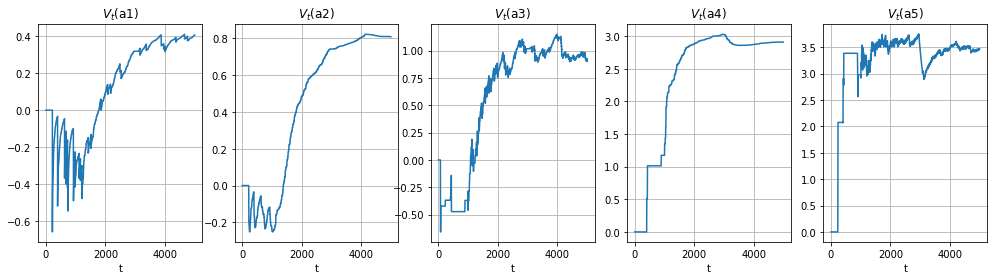

In [ ]:
# Q ucenje
T = 5000 # broj epoha
# funkcije akcije
q = np.zeros([5,4]) # 5 mogucih stanja sem terminalnih i usvakom po 4 akcije
V = np.zeros([5,T])
gama = 0.9 # faktor umanjenja buducih nagrada
stanje ='a1' # pocetno stanje je uvijek isto
epsilon = 0.05 # gramzivo istrazivanje
num = 0
e  = 0 # redni broj epizode

for t in range(0,T): # po epohama
  r = nagrade[stanje]
  i = int(stanje[1])-1
  alpha = np.log(e+1)/(e+1)
  #alpha = 0.001
  for j in range(0,4): # po akcijama
      q_pom = r 
      novo_stanje, nagrada, kraj_epizode = simulator(stanje,j,stohasticnost=False)
      if kraj_epizode: 
        q_pom = q_pom + gama * 0.6 * nagrada
      else:
         q_pom = q_pom + gama * 0.6 * max(q[int(novo_stanje[1])-1,:])
      novo_stanje, nagrada, kraj_epizode = simulator(stanje,(j+1) % 4,stohasticnost=False)
      if kraj_epizode:
        q_pom = q_pom + gama * 0.2 * nagrada
      else:
        q_pom = q_pom + gama * 0.2 * max(q[int(novo_stanje[1])-1,:])
      novo_stanje, nagrada, kraj_epizode = simulator(stanje,(j-1) % 4,stohasticnost=False)
      if kraj_epizode:
        q_pom = q_pom + gama * 0.2 * nagrada
      else:
        q_pom = q_pom + gama * 0.2 * max(q[int(novo_stanje[1])-1,:])
      q[i,j] = q[i,j] + alpha * (q_pom - q[i,j])
  if np.random.rand() < epsilon:
    akcija = int(np.floor(np.random.rand()*4))
    num = num + 1
  else:
    akcija = np.argmax(q[i,:])
  stanje, nagrada, kraj_epizode = simulator(stanje,akcija)
  if kraj_epizode:
    e = e + 1
  V[:,t] = np.max(q,axis = 1)


politika = np.argmax(q,axis = 1)
print(politika)

print('Broj stohasticnih akcija ' + str(num))      
print('Broj epizoda ' + str(e))      
print(q)

plt.figure(figsize=(17,4))
for i in range(0,5):
  plt.subplot(1,5,i+1)
  plt.plot(V[i,:])
  plt.grid()
  plt.title('$V_{t}$(a'+str(i+1)+')')
  plt.xlabel('t')

In [ ]:
print('Prosjecna nagrada je: '+ str(procjena_nagrade(politika)))

Prosjecna nagrada je: 2.6


In [ ]:
# Reinforcement

T = 1000 # broj epoha
q = np.zeros([5,4]) # 5 mogucih stanja sem terminalnih i usvakom po 4 akcije
V = np.zeros([5,T])
gama = 0.9 # faktor umanjenja buducih nagrada
stanje ='a1' # pocetno stanje je uvijek isto
epsilon = 0.05 # gramzivo istrazivanje
num = 0
e  = 0 # redni broj epizode
politika = [0,0,0,0,0]
niz_nagrada = np.array([])
theta = np.zeros([5,4])
#fi = [[2,1,0,0.5],[1,2,0,0.5],[2,1,1,0],[1,2,0,0.5],[0,1,2,0]]
fi = [[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]]
fi = np.array(fi)
parametri_politike = np.zeros([5,4,T])
vjerovatnoce = np.zeros([5,4,T])

for t in range(0,T): # po epohama
  #alpha = np.log(e+1)/(e+1)
  alpha = 0.025
  pi_politika = np.exp(theta)
  for i in range(len(pi_politika)):
    pi_politika[i,:] = pi_politika[i,:] / sum(pi_politika[i,:])
  politika_nova = np.argmax(pi_politika,axis = 1)
  politika = politika_nova
  parametri_politike[:,:,t] = theta
  vjerovatnoce[:,:,t] = pi_politika
  kraj_epizode = False
  zarade = np.array([0])
  stanja = []
  akcije = []
  # istrazivanje
  while not(kraj_epizode):
    stanje_br = int(stanje[1])-1
    stanja = np.append(stanja,stanje_br)
    if np.random.rand() < epsilon:
      akcija = int(np.floor(np.random.rand()*4))
      num = num + 1
    else:
      akcija = np.argmax(pi_politika[stanje_br,:])
    akcije = np.append(akcije,akcija)
    novo_stanje, nagrada, kraj_epizode = simulator(stanje,akcija)
    zarade = np.append(zarade,nagrada)
    stanje = novo_stanje
  e = e + 1
  i = len(zarade) - 2
  # racunanje zarade
  zarade = list(zarade)
  while i>=0 :
    zarade[i] = zarade[i] + gama * zarade[i+1]
    i = i - 1
  # azuriranje parametara politike
  for i in range(0,len(zarade)-1):
    stanje_br = round(stanja[i])
    akcija_br = round(akcije[i])
    delta = fi[stanje_br,akcija_br] + sum(fi[stanje_br,:]*pi_politika[stanje_br,:])
    theta[stanje_br,akcija_br] = theta[stanje_br,akcija_br] + alpha * zarade[i] * delta
  if not(e % 1):
    niz_nagrada = np.append(niz_nagrada, procjena_nagrade(politika))

print(politika)

[1 1 1 1 2]


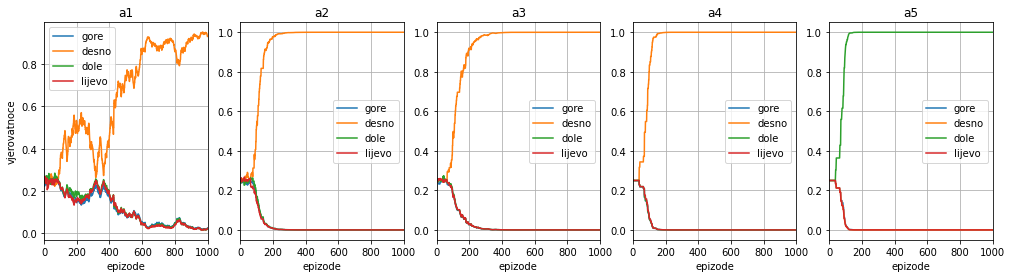

In [ ]:
plt.figure(figsize=(17,4))
for i in range(0,5):
  plt.subplot(1,5,i+1)
  for j in range(0,4):
    plt.plot(vjerovatnoce[i,j,:])
  plt.grid()
  plt.xlim([0,1000])
  plt.title('a'+str(i+1))
  plt.xlabel('epizode')
  if i==0:
    plt.ylabel('vjerovatnoce')
  plt.legend(['gore','desno','dole','lijevo'])

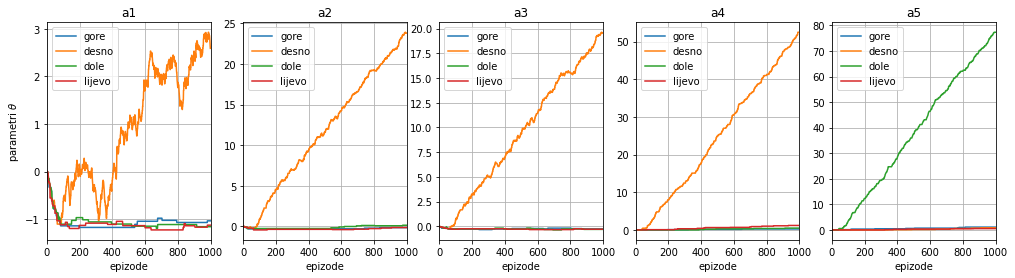

In [ ]:
plt.figure(figsize=(17,4))
for i in range(0,5):
  plt.subplot(1,5,i+1)
  for j in range(0,4):
    plt.plot(parametri_politike[i,j,:])
  plt.grid()
  plt.xlim([0,1000])
  plt.title('a'+str(i+1))
  plt.xlabel('epizode')
  if i==0:
    plt.ylabel('parametri '+r'$\theta$')
  plt.legend(['gore','desno','dole','lijevo'])

Text(0, 0.5, 'nagrada')

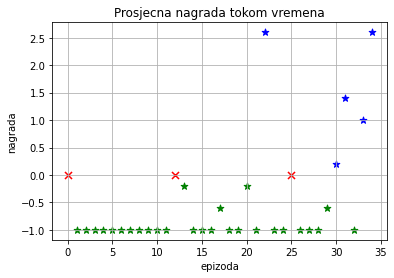

In [ ]:
niz_nagrada = niz_nagrada[0:35]
for i in range(0,len(niz_nagrada)):
  if niz_nagrada[i] > 0:
    plt.scatter(i, niz_nagrada[i], c ='b', s = 50, marker = '*')
  elif niz_nagrada[i] < -8:
    plt.scatter(i, 0, c ='r', s = 50, marker = 'x')
  else:
    plt.scatter(i, niz_nagrada[i], c ='g', s = 50, marker = '*')

plt.grid()
plt.title('Prosjecna nagrada tokom vremena')
plt.xlabel('epizoda')
plt.ylabel('nagrada')

Text(0, 0.5, 'nagrada')

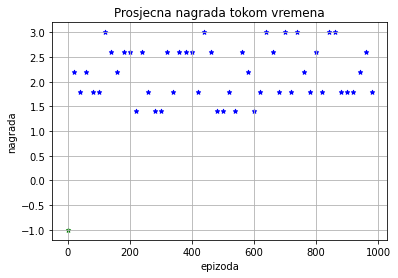

In [ ]:
for i in range(0,len(niz_nagrada)):
  if niz_nagrada[i] > 0:
    plt.scatter(i*20, niz_nagrada[i], c ='b', s = 20, marker = '*')
  elif niz_nagrada[i] < -8:
    plt.scatter(i*20, 0, c ='r', s = 20, marker = 'x')
  else:
    plt.scatter(i*20, niz_nagrada[i], c ='g', s = 20, marker = '*')

plt.grid()
plt.title('Prosjecna nagrada tokom vremena')
plt.xlabel('epizoda')
plt.ylabel('nagrada')
